## 📦 Installation des dépendances

In [1]:
%pip install --upgrade pip setuptools==65.5.0
%pip install opencv-python  pandas joblib scikit-learn matplotlib seaborn   gTTS  arabic_reshaper python-bidi mediapipe
%pip install playsound==1.2.2
%pip install imbalanced-learn numpy
%pip install imgaug

  Using cached setuptools-65.5.0-py3-none-any.whl.metadata (6.3 kB)
Using cached setuptools-65.5.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.8.0
    Uninstalling setuptools-75.8.0:
      Successfully uninstalled setuptools-75.8.0
Note: you may need to restart the kernel to use updated packages.
  Using cached arabic_reshaper-3.0.0-py3-none-any.whl.metadata (12 kB)
  Using cached python_bidi-0.6.6-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
Using cached arabic_reshaper-3.0.0-py3-none-any.whl (20 kB)
Using cached python_bidi-0.6.6-cp312-cp312-win_amd64.whl (160 kB)

   ---------------------------------------- 0/2 [python-bidi]
   ---------------------------------------- 0/2 [python-bidi]
   ---------------------------------------- 0/2 [python-bidi]
   -------------------- ------------------- 1/2 [arabic_reshaper]
   -------------------- ------------------- 1/2 [arabic_reshaper]
   ---------------------------------------- 2

=============================================
                 📚 Importation des bibliothèques
=============================================

In [1]:
# Outils système et gestion de fichiers
import os
import numpy as np
import pandas as pd

# Vision par ordinateur et traitement d'images
import cv2
import mediapipe as mp
mp_hands = mp.solutions.hands
from imgaug import augmenters as iaa

# Machine Learning - Modèles & Évaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from scipy.stats import randint, uniform 
from sklearn.preprocessing import StandardScaler
import joblib 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Multimédia et audio
from gtts import gTTS   # Text-to-speech
from playsound import playsound
import time
from PIL import ImageFont, ImageDraw, Image
from bidi.algorithm import get_display

# Affichage du texte arabe
import arabic_reshaper
import tempfile
import threading
import sys
import subprocess

=============================================
                 ✋ Extraction des landmarks 
=============================================

In [ ]:
def initialize_mediapipe():
    mp_hands = mp.solutions.hands
    return mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.3,
        min_tracking_confidence=0.3
    )


In [13]:
def extract_landmarks(image_path, hands_model):
    image = cv2.imread(image_path)
    if image is None:
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands_model.process(image_rgb)

    if results.multi_hand_landmarks:
        landmarks = []
        for lm in results.multi_hand_landmarks[0].landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
        return landmarks
    else:
        return None

In [14]:
def process_folder(folder_path, folder_name, hands_model):
    count = 0
    skipped = 0
    data = []
    labels = []

    for img_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, img_file)
        landmarks = extract_landmarks(image_path, hands_model)

        if landmarks:
            data.append(landmarks)
            labels.append(folder_name)
            count += 1
        else:
            skipped += 1

    print(f"Count {count} folder :'{folder_name}' | Skipped: {skipped}")
    return data, labels

In [15]:
def process_dataset(dataset_path, hands_model):
    all_data = []
    all_labels = []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if not os.path.isdir(folder_path):
            print(f"{folder} n'est pas un dossier valide")
            continue

        data, labels = process_folder(folder_path, folder, hands_model)
        all_data.extend(data)
        all_labels.extend(labels)

    return all_data, all_labels

In [16]:
def save_to_csv(data, labels, filename):
    if data:
        df = pd.DataFrame(data)
        df.insert(0, 'label', labels)
        df.to_csv(filename, index=False)
        print(f"\nDonnées sauvegardées avec succès !")
        print(f"Nombre total d'échantillons : {len(df)}")
        print(f"Dimensions du CSV : {df.shape}")
    else:
        print("\nAucune donnée n'a été extraite. Vérifiez vos images et leur contenu.")

In [26]:
hands_model = initialize_mediapipe()

dataset_path = "Data"
data, labels = process_dataset(dataset_path, hands_model)
save_to_csv(data, labels, "donnees_originales.csv")

hands_model.close()


Count 213 folder :'Ain' | Skipped: 31
Count 272 folder :'Al' | Skipped: 4
Count 266 folder :'Alef' | Skipped: 21
Count 280 folder :'Beh' | Skipped: 27
Count 258 folder :'Dad' | Skipped: 8
Count 220 folder :'Dal' | Skipped: 15
Count 241 folder :'Feh' | Skipped: 14
Count 222 folder :'Ghain' | Skipped: 8
Count 198 folder :'Hah' | Skipped: 48
Count 217 folder :'Heh' | Skipped: 36
Count 195 folder :'Jeem' | Skipped: 15
Count 256 folder :'Kaf' | Skipped: 8
Count 208 folder :'Khah' | Skipped: 42
Count 246 folder :'Laa' | Skipped: 22
Count 252 folder :'Lam' | Skipped: 8
Count 243 folder :'Meem' | Skipped: 10
Count 218 folder :'Noon' | Skipped: 19
Count 201 folder :'Qaf' | Skipped: 18
Count 207 folder :'Reh' | Skipped: 20
Count 262 folder :'Sad' | Skipped: 8
Count 263 folder :'Seen' | Skipped: 3
Count 276 folder :'Sheen' | Skipped: 2
Count 205 folder :'Tah' | Skipped: 21
Count 285 folder :'Teh' | Skipped: 26
Count 236 folder :'Teh_Marbuta' | Skipped: 21
Count 191 folder :'Thal' | Skipped: 11
Co

In [17]:
def visualiser_distribution_classes(fichier_csv):
    df = pd.read_csv(fichier_csv)
    sns.countplot(data=df, x='label')
    plt.xticks(rotation=90)
    plt.title("Class Distribution")
    plt.show()  

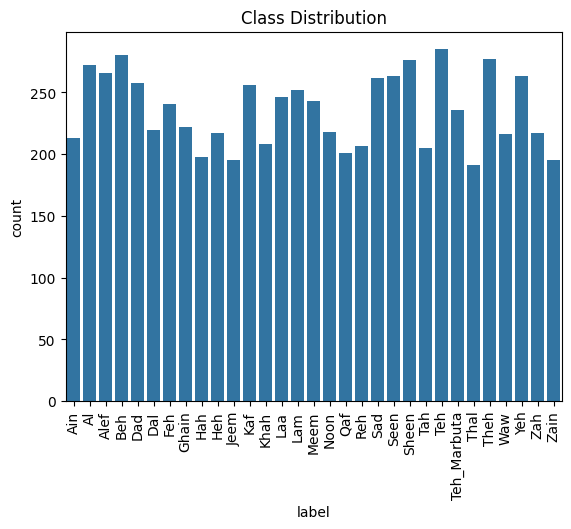

In [30]:
visualiser_distribution_classes( "donnees_originales.csv")

=============================================
                ↗️ Data Augementation
=============================================

In [7]:
# Séquence d’augmentations
augmentation = iaa.Sequential([
    iaa.Affine(rotate=(-15, 15)),        # Rotation légère
    iaa.GaussianBlur(sigma=(0.0, 1.0)),  # Flou gaussien
    iaa.Multiply((0.8, 1.2))             # Variation de luminosité
])

def augmenter_donnees(dataset_path, hands, echantillons_cibles_par_classe=2000):
    donnees_aug = []
    etiquettes_aug = []

    for dossier in os.listdir(dataset_path):
        chemin_dossier = os.path.join(dataset_path, dossier)
        if not os.path.isdir(chemin_dossier):
            continue

        fichiers = os.listdir(chemin_dossier)
        if not fichiers:
            continue

        count = 0
        while count < echantillons_cibles_par_classe:
            img_file = np.random.choice(fichiers)
            image_path = os.path.join(chemin_dossier, img_file)
            image = cv2.imread(image_path)

            if image is None:
                continue

            image_aug = augmentation.augment_image(image)
            image_rgb = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                landmarks = []
                for lm in results.multi_hand_landmarks[0].landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                donnees_aug.append(landmarks)
                etiquettes_aug.append(dossier)
                count += 1

        print(f"{count} échantillons augmentés générés pour la classe : {dossier}")

    return donnees_aug, etiquettes_aug

In [8]:
dataset_path = "Data"
hands = initialize_mediapipe()
donnees_aug, etiquettes_aug = augmenter_donnees(dataset_path, hands, echantillons_cibles_par_classe=2000)
save_to_csv(donnees_aug, etiquettes_aug, "donnees_augmentees.csv")
hands.close() 

2000 échantillons augmentés générés pour la classe : Ain
2000 échantillons augmentés générés pour la classe : Al
2000 échantillons augmentés générés pour la classe : Alef
2000 échantillons augmentés générés pour la classe : Beh
2000 échantillons augmentés générés pour la classe : Dad
2000 échantillons augmentés générés pour la classe : Dal
2000 échantillons augmentés générés pour la classe : Feh
2000 échantillons augmentés générés pour la classe : Ghain
2000 échantillons augmentés générés pour la classe : Hah
2000 échantillons augmentés générés pour la classe : Heh
2000 échantillons augmentés générés pour la classe : Jeem
2000 échantillons augmentés générés pour la classe : Kaf
2000 échantillons augmentés générés pour la classe : Khah
2000 échantillons augmentés générés pour la classe : Laa
2000 échantillons augmentés générés pour la classe : Lam
2000 échantillons augmentés générés pour la classe : Meem
2000 échantillons augmentés générés pour la classe : Noon
2000 échantillons augment

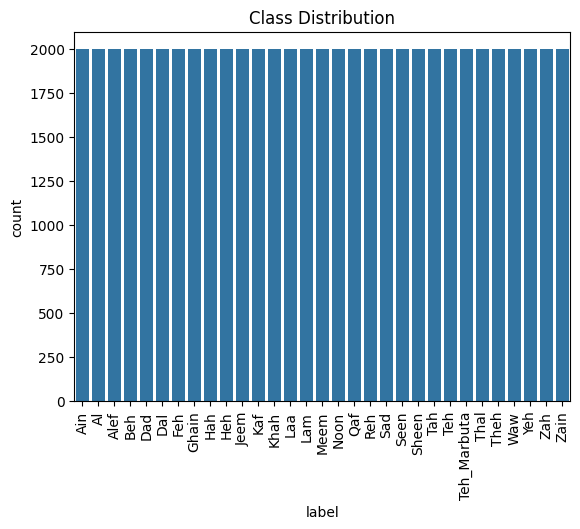

In [18]:
visualiser_distribution_classes("donnees_augmentees.csv")

=============================================
              👩‍💻Data Exploration
=============================================

In [2]:
df = pd.read_csv("donnees_augmentees.csv")
print(df.head(2))

  label         0         1             2         3         4         5  \
0   Ain  0.869198  0.911362  1.523581e-07  0.803290  0.799681  0.032360   
1   Ain  1.041637  0.640096 -1.090848e-06  0.959658  0.534145 -0.018479   

          6         7         8  ...        53        54        55        56  \
0  0.664988  0.727434  0.029251  ... -0.128496  0.421319  0.896383 -0.137544   
1  0.783906  0.479499 -0.075776  ... -0.257799  0.653736  0.701600 -0.295148   

         57        58        59        60        61        62  
0  0.484378  0.920529 -0.118291  0.545903  0.914824 -0.100712  
1  0.703451  0.693697 -0.261791  0.778067  0.671175 -0.239695  

[2 rows x 64 columns]


In [3]:
print(df['label'].value_counts())

label
Ain            2000
Noon           2000
Zah            2000
Yeh            2000
Waw            2000
Theh           2000
Thal           2000
Teh_Marbuta    2000
Teh            2000
Tah            2000
Sheen          2000
Seen           2000
Sad            2000
Reh            2000
Qaf            2000
Meem           2000
Al             2000
Lam            2000
Laa            2000
Khah           2000
Kaf            2000
Jeem           2000
Heh            2000
Hah            2000
Ghain          2000
Feh            2000
Dal            2000
Dad            2000
Beh            2000
Alef           2000
Zain           2000
Name: count, dtype: int64


In [4]:
print(df.describe())

                  0             1             2             3             4  \
count  62000.000000  62000.000000  6.200000e+04  62000.000000  62000.000000   
mean       0.465962      0.748413  2.280404e-07      0.513623      0.685325   
std        0.177119      0.144291  1.188904e-06      0.164462      0.131551   
min       -0.154283     -0.004501 -5.178653e-06     -0.084985      0.071792   
25%        0.358784      0.664949 -6.698094e-07      0.407760      0.598337   
50%        0.466845      0.767993  3.128701e-07      0.524241      0.698872   
75%        0.570405      0.855008  1.091074e-06      0.626840      0.783465   
max        1.153211      1.083376  6.247609e-06      1.047610      1.017091   

                  5             6             7             8             9  \
count  62000.000000  62000.000000  62000.000000  62000.000000  62000.000000   
mean      -0.054911      0.539491      0.596027     -0.091019      0.546833   
std        0.075482      0.175998      0.116992    

=============================================
              ➗Train-Test Split
=============================================

In [5]:
X= df.drop('label', axis=1)
y = df['label']

In [6]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Training Set:", X_train.shape[0])
print("Validation Set:", X_val.shape[0])
print("Test Set:", X_test.shape[0])

Training Set: 37200
Validation Set: 12400
Test Set: 12400


=============================================
             🤖Model Training
=============================================

In [7]:
# 1. Initialize with reasonable defaults (similar to your grid's middle values)
model = RandomForestClassifier(n_estimators=200)

# 2. Train the model
model.fit(X_train, y_train)

# 3. Evaluate on test set
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.9886290322580645
Test Accuracy: 0.9888709677419355
              precision    recall  f1-score   support

         Ain       0.99      0.99      0.99       400
          Al       1.00      0.99      0.99       400
        Alef       0.99      1.00      0.99       400
         Beh       0.99      0.99      0.99       400
         Dad       0.99      0.99      0.99       400
         Dal       0.97      0.99      0.98       400
         Feh       0.99      0.99      0.99       400
       Ghain       0.99      0.99      0.99       400
         Hah       0.96      0.98      0.97       400
         Heh       0.99      1.00      0.99       400
        Jeem       0.99      0.99      0.99       400
         Kaf       0.98      1.00      0.99       400
        Khah       0.98      0.97      0.98       400
         Laa       1.00      1.00      1.00       400
         Lam       1.00      0.99      0.99       400
        Meem       1.00      0.99      0.99       400
       

# matrice_confusion

In [8]:
def afficher_matrice_confusion(y_test, y_test_pred, model, titre="Matrice de confusion pour la reconnaissance des lettres arabes"):

    # Création de la matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Récupération des noms de classes (lettres arabes)
    labels = model.classes_

    # Affichage
    plt.figure(figsize=(18, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Titres et axes
    plt.xlabel('Classe prédite', fontsize=14)
    plt.ylabel('Classe réelle', fontsize=14)
    plt.title(titre, fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

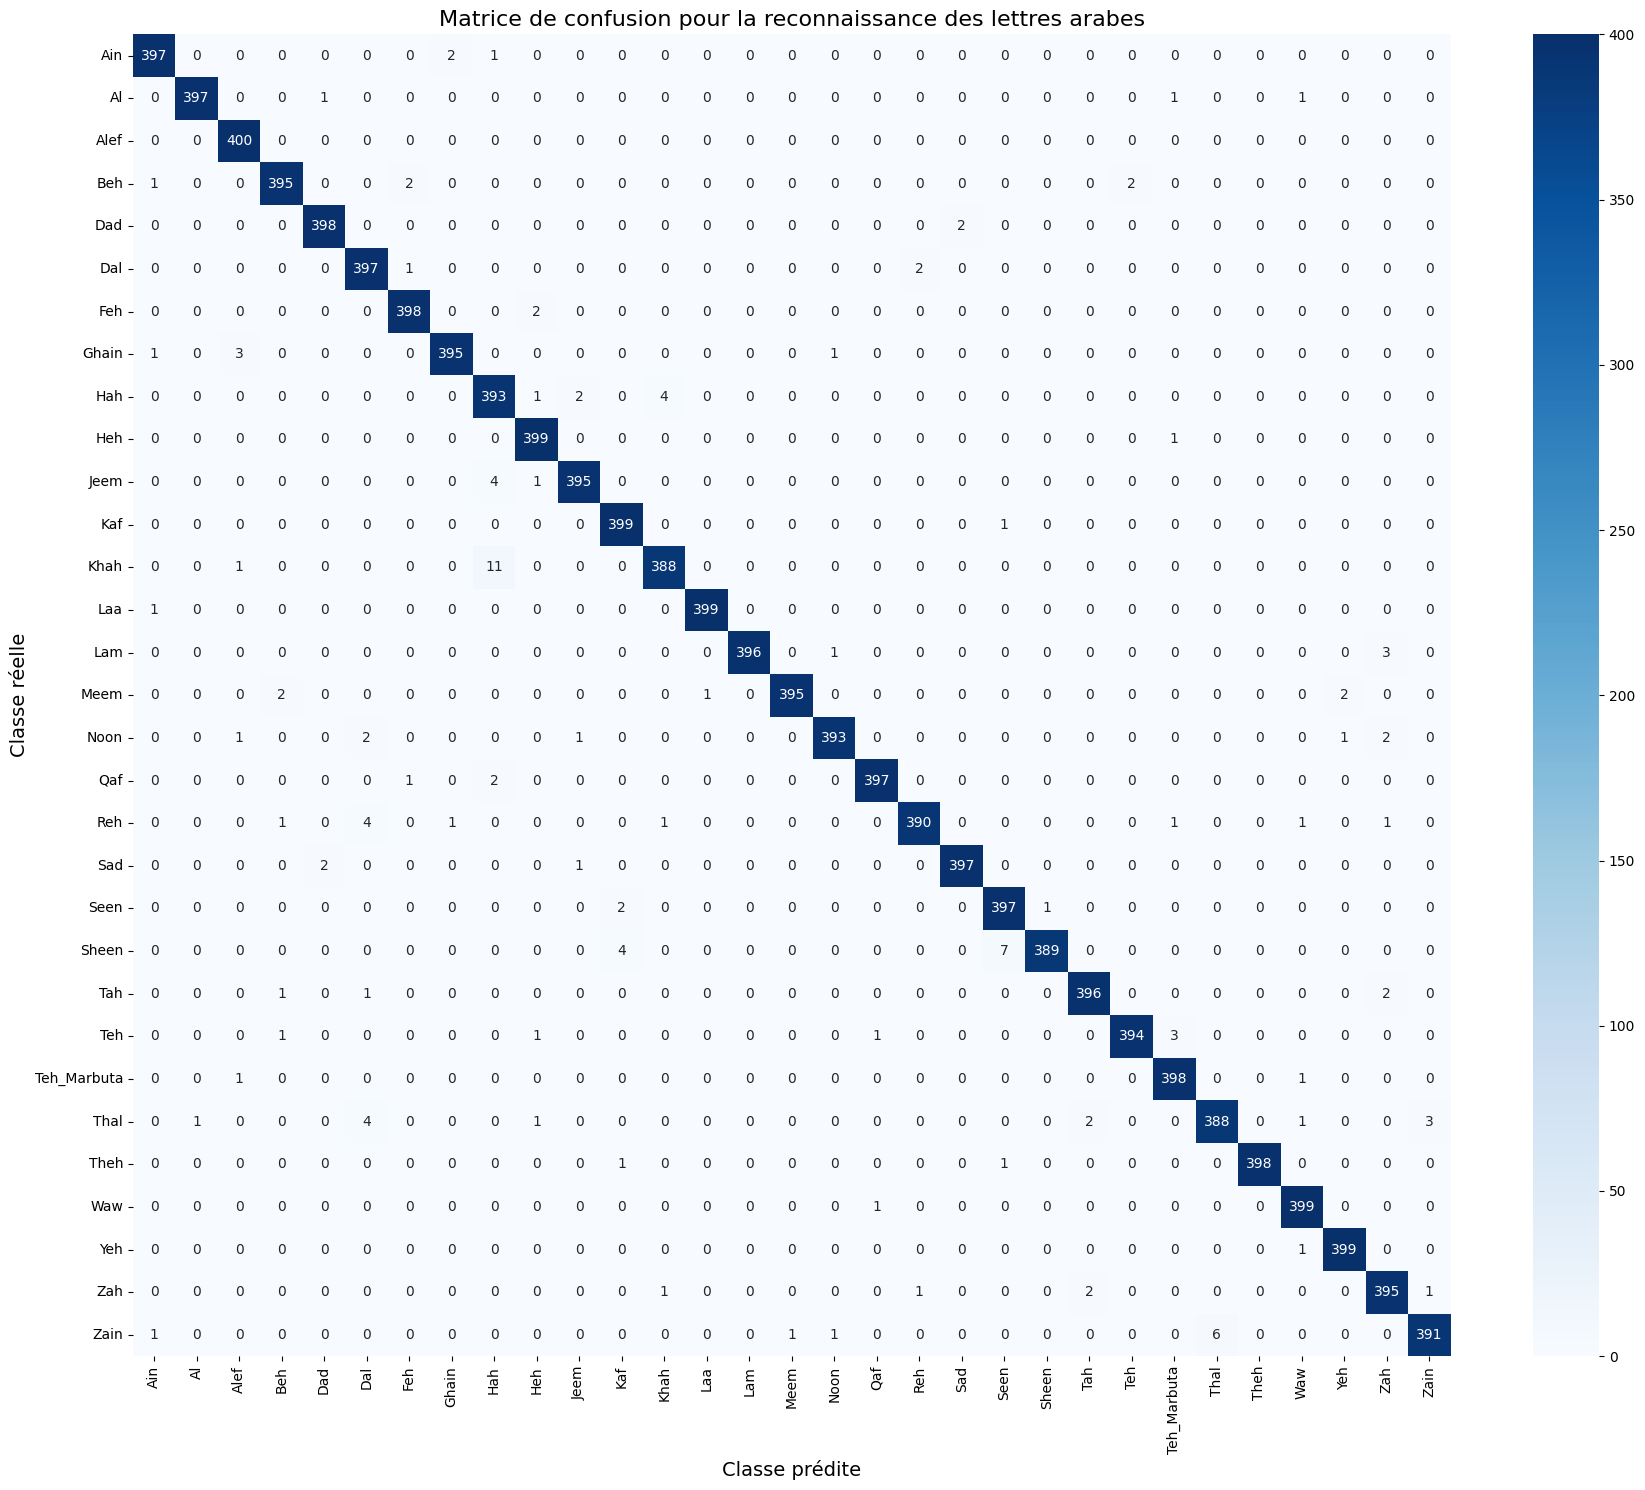

In [9]:
afficher_matrice_confusion(y_test, y_test_pred, model)

=============================================
             🕶️Random Search
=============================================

In [12]:
# 1. Définir l'espace des hyperparamètres à explorer
param_dist = {
    'n_estimators': randint(100, 500),        # Nombre d'arbres
    'max_depth': [None, 10, 20, 30, 40],      # Profondeur max
    'min_samples_split': randint(2, 11),      # Nb minimum pour spliter
    'min_samples_leaf': randint(1, 6),        # Nb minimum dans une feuille
    'max_features': ['sqrt', 'log2', None],   # Features à considérer
    'bootstrap': [True, False]                # Avec ou sans remise
}

# 2. Initialiser le modèle
model = RandomForestClassifier(random_state=42)

# 3. Configurer RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,               
    cv=5,                    
    scoring='accuracy',
    n_jobs=-1,              
    random_state=42
)

# 4. Lancer la recherche sur l'ensemble d'entraînement
print("Début de la recherche aléatoire...")
random_search.fit(X_train, y_train)


# 5. Meilleurs paramètres trouvés
print("\nMeilleurs paramètres trouvés:")
print(random_search.best_params_)

# 6. Utiliser le meilleur modèle trouvé
best_model = random_search.best_estimator_

# 7. Prédiction sur validation et test
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# 8. Évaluation
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nRapport de classification sur Test Set:")
print(classification_report(y_test, y_test_pred))

Début de la recherche aléatoire...

Meilleurs paramètres trouvés:
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 463}

Validation Accuracy: 0.9884677419354839
Test Accuracy: 0.9887096774193549

Rapport de classification sur Test Set:
              precision    recall  f1-score   support

         Ain       0.99      0.99      0.99       400
          Al       1.00      0.99      0.99       400
        Alef       0.98      1.00      0.99       400
         Beh       0.99      0.99      0.99       400
         Dad       0.99      0.99      0.99       400
         Dal       0.98      0.99      0.99       400
         Feh       0.99      0.99      0.99       400
       Ghain       0.99      0.98      0.99       400
         Hah       0.96      0.99      0.97       400
         Heh       0.98      0.99      0.99       400
        Jeem       0.99      0.98      0.99       400
         Kaf       0.98      1.00    

=============================================
                 📜Model Saving
=============================================

In [10]:
# Save both model and scaler
joblib.dump(model, "random_forest_model.pkl")

print("Model and scaler saved successfully.")

Model and scaler saved successfully.


=============================================
                🛑Result 
=============================================

For Windows 

In [11]:
# ----------------------------
# Load model 
# ----------------------------
model = joblib.load("random_forest_model.pkl")

# ----------------------------
# Arabic label mapping
# ----------------------------
label_to_arabic = {
    "Ain": "ع", "Al": "ٱ", "Alef": "ا", "Beh": "ب", "Dad": "ض", "Dal": "د",
    "Feh": "ف", "Ghain": "غ", "Hah": "ح", "Heh": "ھ", "Jeem": "ج", "Kaf": "ك",
    "Khah": "خ", "Laa": "لا", "Lam": "ل", "Meem": "م", "Noon": "ن", "Qaf": "ق",
    "Reh": "ر", "Sad": "ص", "Seen": "س", "Sheen": "ش", "Tah": "ط", "Teh": "ت",
    "Teh_Marbuta": "ة", "Thal": "ذ", "Theh": "ث", "Waw": "و", "Yeh": "ي",
    "Zah": "ظ", "Zain": "ز"
}

# ----------------------------
# Speak Arabic function (Updated)
# ----------------------------
def speak_arabic(text):
    if not text.strip():
        return
    
    try:
        # Create temp file path
        temp_dir = tempfile.gettempdir()
        temp_path = os.path.join(temp_dir, f"arabic_tts_{int(time.time())}.mp3")
        
        # Generate speech
        tts = gTTS(text=text, lang='ar')
        tts.save(temp_path)
        
        # Play using default app (works if Windows knows how to open .mp3 files)
        os.startfile(temp_path)

        # Delete after delay
        threading.Timer(5.0, lambda: os.remove(temp_path) if os.path.exists(temp_path) else None).start()

    except Exception as e:
        print(f"[ERROR] في speak_arabic: {str(e)}")

# ----------------------------
# MediaPipe setup
# ----------------------------
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)
mp_drawing = mp.solutions.drawing_utils

# ----------------------------
# Webcam setup
# ----------------------------
cap = cv2.VideoCapture(0)

# ----------------------------
# State variables
# ----------------------------
confirmed_word = ""
arabic_letter = ""
last_stable_label = None
label_hold_start = None
hold_duration_required = 2
last_hand_time = time.time()
space_inserted = False
spoken_once = False

# ----------------------------
# Font setup
# ----------------------------
try:
    font_path = "f.ttf"
    font = ImageFont.truetype(font_path, 48)
except:
    print("تحذير: الخط المخصص غير موجود، سيتم استخدام الخط الافتراضي")
    font = ImageFont.load_default()

# ----------------------------
# Reset button area
# ----------------------------
reset_button_area = (500, 10, 680, 60)

# ----------------------------
# Mouse callback
# ----------------------------
def mouse_callback(event, x, y, flags, param):
    global confirmed_word, last_stable_label, label_hold_start, space_inserted, spoken_once
    if event == cv2.EVENT_LBUTTONDOWN:
        if reset_button_area[0] <= x <= reset_button_area[2] and reset_button_area[1] <= y <= reset_button_area[3]:
            print("[INFO] تم إعادة تعيين الجملة.")
            confirmed_word = ""
            last_stable_label = None
            label_hold_start = None
            space_inserted = False
            spoken_once = False

# ----------------------------
# Main loop
# ----------------------------
cv2.namedWindow("hand sign interpreter")
cv2.setMouseCallback("hand sign interpreter", mouse_callback)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb)

    hand_detected = False

    if result.multi_hand_landmarks:
        hand_detected = True
        last_hand_time = time.time()
        space_inserted = False
        spoken_once = False

        for hand_landmarks in result.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            landmarks = [coord for lm in hand_landmarks.landmark for coord in (lm.x, lm.y, lm.z)]

            if len(landmarks) == 63:
                input_data = np.array(landmarks).reshape(1, -1)
                predicted_label = model.predict(input_data)[0].strip().capitalize()  # بدون استخدام scaler
                arabic_letter = label_to_arabic.get(predicted_label, "?")

                current_time = time.time()
                if predicted_label != last_stable_label:
                    last_stable_label = predicted_label
                    label_hold_start = current_time
                else:
                    if label_hold_start and (current_time - label_hold_start) >= hold_duration_required:
                        confirmed_letter = label_to_arabic.get(predicted_label, "?")
                        confirmed_word += confirmed_letter
                        last_stable_label = None
                        label_hold_start = None
    else:
        current_time = time.time()
        if (current_time - last_hand_time) > 2 and not space_inserted:
            confirmed_word += " "
            space_inserted = True
            if confirmed_word.strip() and not spoken_once:
                print(f"جارٍ قراءة الجملة: {confirmed_word.strip()}")
                speak_arabic(confirmed_word.strip())
                spoken_once = True
        label_hold_start = None

    # Prepare Arabic text for display
    display_full_letter = get_display(arabic_reshaper.reshape(f"الحرف: {arabic_letter}"))
    display_full_word = get_display(arabic_reshaper.reshape(f"الكلمة: {confirmed_word}"))

    # Draw on PIL image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    # Draw text
    draw.text((10, 10), display_full_letter, font=font, fill=(0, 255, 0))
    draw.text((10, 70), display_full_word, font=font, fill=(0, 0, 255))

    # Progress bar
    if label_hold_start:
        progress_duration = time.time() - label_hold_start
        progress_ratio = min(progress_duration / hold_duration_required, 1.0)
        bar_x, bar_y = 10, 120
        bar_width, bar_height = 200, 20
        fill_width = int(bar_width * progress_ratio)
        draw.rectangle([bar_x, bar_y, bar_x + bar_width, bar_y + bar_height], outline="gray", width=2)
        draw.rectangle([bar_x, bar_y, bar_x + fill_width, bar_y + bar_height], fill="green")

    # Draw reset button
    btn_x1, btn_y1, btn_x2, btn_y2 = reset_button_area
    button_center_x = (btn_x1 + btn_x2) // 2
    button_center_y = (btn_y1 + btn_y2) // 2

    def draw_rounded_rectangle(draw, xy, radius, fill, outline=None, outline_width=1):
        x1, y1, x2, y2 = xy
        draw.rounded_rectangle(xy, radius=radius, fill=fill, outline=outline, width=outline_width)

    draw_rounded_rectangle(
        draw,
        (btn_x1, btn_y1, btn_x2, btn_y2),
        radius=15,
        fill=(220, 30, 30),
        outline=(255, 255, 255),
        outline_width=2
    )

    # Button text
    button_text = get_display(arabic_reshaper.reshape("إعادة"))
    bbox = font.getbbox(button_text)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    text_x = button_center_x - text_width // 2
    text_y = button_center_y - text_height // 2 - 30
    draw.text((text_x, text_y), button_text, font=font, fill=(255, 255, 255))

    # Display final frame
    frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    cv2.imshow("hand sign interpreter", frame)

    # Keyboard controls
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC
        break
    elif key == 32:  # SPACE to reset
        confirmed_word = ""
        last_stable_label = None
        label_hold_start = None
        space_inserted = False
        spoken_once = False
    elif key == ord('u'):  # Undo
        confirmed_word = confirmed_word[:-1]

# ----------------------------
# Cleanup
# ----------------------------
cap.release()
cv2.destroyAllWindows()

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feat

جارٍ قراءة الجملة: ككسل


Exception in thread Thread-4:
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1431, in run
    self.function(*self.args, **self.kwargs)
  File "C:\Users\Dell\AppData\Local\Temp\ipykernel_8940\2394566283.py", line 38, in <lambda>
PermissionError: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'C:\\Users\\Dell\\AppData\\Local\\Temp\\arabic_tts_1748539473.mp3'


for mac

In [ ]:

# Load model only
model = joblib.load("random_forest_model.pkl")

# Arabic label mapping
label_to_arabic = {
    "Ain": "ع", "Al": "ٱ", "Alef": "ا", "Beh": "ب", "Dad": "ض", "Dal": "د",
    "Feh": "ف", "Ghain": "غ", "Hah": "ح", "Heh": "ھ", "Jeem": "ج", "Kaf": "ك",
    "Khah": "خ", "Laa": "لا", "Lam": "ل", "Meem": "م", "Noon": "ن", "Qaf": "ق",
    "Reh": "ر", "Sad": "ص", "Seen": "س", "Sheen": "ش", "Tah": "ط", "Teh": "ت",
    "Teh_Marbuta": "ة", "Thal": "ذ", "Theh": "ث", "Waw": "و", "Yeh": "ي",
    "Zah": "ظ", "Zain": "ز"
}

# Speak Arabic sentence
def speak_arabic(text):
    tts = gTTS(text=text, lang='ar')
    tts.save("temp_arabic.mp3")
    os.system("afplay temp_arabic.mp3")  # On macOS
    os.remove("temp_arabic.mp3")

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)
mp_drawing = mp.solutions.drawing_utils

# Webcam
cap = cv2.VideoCapture(1)

# State
confirmed_word = ""
arabic_letter = ""
last_stable_label = None
label_hold_start = None
hold_duration_required = 2

last_hand_time = time.time()
space_inserted = False
spoken_once = False

# Font
font_path = "f.ttf"
font = ImageFont.truetype(font_path, 48)

# Reset button area
reset_button_area = (500, 10, 680, 60)

# Mouse callback
def mouse_callback(event, x, y, flags, param):
    global confirmed_word, last_stable_label, label_hold_start, space_inserted, spoken_once
    if event == cv2.EVENT_LBUTTONDOWN:
        if reset_button_area[0] <= x <= reset_button_area[2] and reset_button_area[1] <= y <= reset_button_area[3]:
            print("[INFO] Sentence reset by click.")
            confirmed_word = ""
            last_stable_label = None
            label_hold_start = None
            space_inserted = False
            spoken_once = False

cv2.namedWindow("hand sign interpreter")
cv2.setMouseCallback("hand sign interpreter", mouse_callback)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb)

    hand_detected = False

    if result.multi_hand_landmarks:
        hand_detected = True
        last_hand_time = time.time()
        space_inserted = False
        spoken_once = False

        for hand_landmarks in result.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            landmarks = [coord for lm in hand_landmarks.landmark for coord in (lm.x, lm.y, lm.z)]

            if len(landmarks) == 63:
                input_data = np.array(landmarks).reshape(1, -1)
                predicted_label = model.predict(input_data)[0].strip().capitalize()
                arabic_letter = label_to_arabic.get(predicted_label, "?")

                current_time = time.time()
                if predicted_label != last_stable_label:
                    last_stable_label = predicted_label
                    label_hold_start = current_time
                else:
                    if label_hold_start and (current_time - label_hold_start) >= hold_duration_required:
                        confirmed_letter = label_to_arabic.get(predicted_label, "?")
                        confirmed_word += confirmed_letter
                        last_stable_label = None
                        label_hold_start = None
    else:
        current_time = time.time()
        if (current_time - last_hand_time) > 2 and not space_inserted:
            confirmed_word += " "
            space_inserted = True
            if confirmed_word.strip() and not spoken_once:
                speak_arabic(confirmed_word.strip())
                spoken_once = True
        label_hold_start = None

    # Display reshaped text
    display_full_letter = get_display(arabic_reshaper.reshape(f"الحرف: {arabic_letter}"))
    display_full_word = get_display(arabic_reshaper.reshape(f"الكلمة: {confirmed_word}"))

    # Draw via PIL
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    draw.text((10, 10), display_full_letter, font=font, fill=(0, 255, 0))
    draw.text((10, 70), display_full_word, font=font, fill=(0, 0, 255))

    # Progress bar
    if label_hold_start:
        progress_duration = time.time() - label_hold_start
        progress_ratio = min(progress_duration / hold_duration_required, 1.0)
        bar_x, bar_y = 10, 120
        bar_width, bar_height = 200, 20
        fill_width = int(bar_width * progress_ratio)
        draw.rectangle([bar_x, bar_y, bar_x + bar_width, bar_y + bar_height], outline="gray", width=2)
        draw.rectangle([bar_x, bar_y, bar_x + fill_width, bar_y + bar_height], fill="green")

    # -----------------------
    # Reset Button Drawing
    # -----------------------
    btn_x1, btn_y1, btn_x2, btn_y2 = reset_button_area
    button_center_x = (btn_x1 + btn_x2) // 2
    button_center_y = (btn_y1 + btn_y2) // 2

    def draw_rounded_rectangle(draw, xy, radius, fill, outline=None, outline_width=1):
        x1, y1, x2, y2 = xy
        draw.rounded_rectangle(xy, radius=radius, fill=fill, outline=outline, width=outline_width)

    draw_rounded_rectangle(
        draw,
        (btn_x1, btn_y1, btn_x2, btn_y2),
        radius=15,
        fill=(220, 30, 30),
        outline=(255, 255, 255),
        outline_width=2
    )

    # Arabic centered text
    button_text = get_display(arabic_reshaper.reshape("إعادة"))
    font_button = ImageFont.truetype(font_path, 52)
    bbox = font_button.getbbox(button_text)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    text_x = button_center_x - text_width // 2
    text_y = button_center_y - text_height // 2 - 30

    draw.text((text_x, text_y), button_text, font=font_button, fill=(255, 255, 255))

    # Final display
    frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    cv2.imshow("hand sign interpreter", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC
        break
    elif key == 32:  # SPACE to reset
        confirmed_word = ""
        last_stable_label = None
        label_hold_start = None
        space_inserted = False
        spoken_once = False
    elif key == ord('u'):  # Undo
        confirmed_word = confirmed_word[:-1]

cap.release()
cv2.destroyAllWindows()